<a class="anchor" id="jump_to_top"></a>
# Data Manipulation
---

### Table of Contents
* [Introduction](#Introduction)
* [Tidy data](#tidy)
    * [Spreading and gathering](#spread-gather)
    * [Separating and uniting](#saparate-unit)
* [Missing values](#na)
* [Relational Data with dplyr](#Relational)
    * [Keys](#Keys)
    * [Mutating Joins](#Joins)
        * [Inner join](#inner)
        * [Outer joins](#outer)
    * [Filtering joins](#filterjoin)
    * [Join problems](#problems)
    * [Set operations](#set)

In [1]:
# loading libraries
library(tidyverse)
library(nycflights13)

# modifying chart size
options(repr.plot.width=5, repr.plot.height=3)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


<a class="anchor" id="Introduction"></a>
## Introduction
Once we bring in the data from an outside source there is no guarantee that it is in a standard format that we are used to. This consistent, clean, and standard format is called **tidy data**. What exactly this tidy format is might not be something that everyone agrees on, but there are aspects of it that are agreeable. Here we will go over some of these methods, will introduce tools provided by **tidyr** and **dplyr**, and by using them will show examples on how to tidy our data and how to join multiple tidy datasets to get the appropriate data we need in our reporting and analysis.

It is typical for a data science project to spend significant amount of time in tidying, transforming and manipulating the data. This is a crucial part of the project that is sometimes overlooked; the output only can get as good as the input, spending some upfront time on the data usually pays off in the end.

<a class="anchor" id="tidy"></a>
## Tidy data
You can represent the same underlying data in multiple ways. The example below shows the same data organized in four different ways. Each dataset shows the same values of four variables `country`, `year`, `population`, and `cases`:

In [2]:
table1

country,year,cases,population
Afghanistan,1999,745,19987071
Afghanistan,2000,2666,20595360
Brazil,1999,37737,172006362
Brazil,2000,80488,174504898
China,1999,212258,1272915272
China,2000,213766,1280428583


In [3]:
table2

country,year,type,count
Afghanistan,1999,cases,745
Afghanistan,1999,population,19987071
Afghanistan,2000,cases,2666
Afghanistan,2000,population,20595360
Brazil,1999,cases,37737
Brazil,1999,population,172006362
Brazil,2000,cases,80488
Brazil,2000,population,174504898
China,1999,cases,212258
China,1999,population,1272915272


In [4]:
table3

country,year,rate
Afghanistan,1999,745/19987071
Afghanistan,2000,2666/20595360
Brazil,1999,37737/172006362
Brazil,2000,80488/174504898
China,1999,212258/1272915272
China,2000,213766/1280428583


Spread across two data frames:

In [5]:
# cases
table4a

country,1999,2000
Afghanistan,745,2666
Brazil,37737,80488
China,212258,213766


In [6]:
# population
table4b

country,1999,2000
Afghanistan,19987071,20595360
Brazil,172006362,174504898
China,1272915272,1280428583


These are all representations of the same underlying data, but they are not equally easy to use. One dataset, the tidy dataset, will be much easier to work with inside the tidyverse.

There are three interrelated rules which make a dataset tidy:

1. Each variable must have its own column.
2. Each observation must have its own row.
3. Each value must have its own cell.

Figure below shows the rules visually

<img src="../png/tidy-1.png" width="800px" align="center">

Or in simpler way we can reduce it to 2 rules:

1. Put each dataset in a data frame (or tibble).
2. Put each variable in a column.

In this example, only table1 is tidy. It's the only representation where each column is a variable.

It's advantageous to have a consistent definition of *tidy* data. This allows to learn the tools that work with that structure. Another big benefit of having variables in columns and observations in rows is that it allows R's vectorized nature to stand out; this includes both the vectorized functionalities within R as well as much higher performance while performing computation within columns.

dplyr, ggplot2, and all the other packages in the tidyverse are designed to work with tidy data.

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="spread-gather"></a>
### Spreading and Gathering
The principles of tidy data seem so obvious that you might wonder if you'll ever encounter a dataset that isn't tidy. Unfortunately, however, most data that you will encounter will be untidy. There are two main reasons:

Most people aren't familiar with the principles of tidy data, and it's hard to derive them yourself unless you spend a lot of time working with data.

Data is often organized to facilitate some use other than analysis. For example, data is often organized to make data entry as easy as possible.

This means for most real analyses, you'll need to do some tidying. The first step is always to figure out what the variables and observations are. Sometimes this is easy; other times you'll need to consult with the people who originally generated the data. The second step is to resolve one of two common problems:

1. One variable might be spread across multiple columns.
2. One observation might be scattered across multiple rows.

Typically a dataset will only suffer from one of these problems; it'll only suffer from both if you're really unlucky! To fix these problems, you'll need the two most important functions in tidyr: `gather()` and `spread()`.

#### Gathering
A common problem is a dataset where some of the column names are not names of variables, but values of a variable. Take `table4a`: the column names `1999` and `2000` represent values of the `year` variable, and each row represents two observations, not one.

In [7]:
table4a

country,1999,2000
Afghanistan,745,2666
Brazil,37737,80488
China,212258,213766


To tidy a dataset like this, we need to "gather" those columns into a new pair of variables. To describe that operation we need three parameters:

* The set of columns that represent values, not variables. In this example, those are the columns `1999` and `2000`.
* The name of the variable whose values form the column names. That is called `key`, and here it is `year`.
* The name of the variable whose values are spread over the cells. That is called `value`, and here it's the number of `cases`.

Together those parameters generate the call to `gather()`:

In [8]:
table4a %>% 
  gather(`1999`, `2000`, key = "year", value = "cases")

country,year,cases
Afghanistan,1999,745
Brazil,1999,37737
China,1999,212258
Afghanistan,2000,2666
Brazil,2000,80488
China,2000,213766


In the final result, the gathered columns are dropped, and we get new `key` and `value` columns. Otherwise, the relationships between the original variables are preserved. Visually, this is shown in figure below 

<img src="../png/gather-table4a.png" width="550px" align="center">

We can use `gather()` to tidy `table4b` in a similar fashion. The only difference is the variable stored in the cell values:

In [9]:
table4b %>% 
  gather(`1999`, `2000`, key = "year", value = "population")

country,year,population
Afghanistan,1999,19987071
Brazil,1999,172006362
China,1999,1272915272
Afghanistan,2000,20595360
Brazil,2000,174504898
China,2000,1280428583


To combine the tidied versions of `table4a` and `table4b` into a single tibble, we need to use `dplyr::left_join()`, which you will learn later in this notebook:

In [10]:
tidy4a <- table4a %>% 
  gather(`1999`, `2000`, key = "year", value = "cases")
tidy4b <- table4b %>% 
  gather(`1999`, `2000`, key = "year", value = "population")
left_join(tidy4a, tidy4b)

Joining, by = c("country", "year")


country,year,cases,population
Afghanistan,1999,745,19987071
Brazil,1999,37737,172006362
China,1999,212258,1272915272
Afghanistan,2000,2666,20595360
Brazil,2000,80488,174504898
China,2000,213766,1280428583


#### Spreading
Spreading is the opposite of gathering. You use it when an observation is scattered across multiple rows. For example, take `table2`: an observation is a country in a year, but each observation is spread across two rows:

In [11]:
table2

country,year,type,count
Afghanistan,1999,cases,745
Afghanistan,1999,population,19987071
Afghanistan,2000,cases,2666
Afghanistan,2000,population,20595360
Brazil,1999,cases,37737
Brazil,1999,population,172006362
Brazil,2000,cases,80488
Brazil,2000,population,174504898
China,1999,cases,212258
China,1999,population,1272915272


To tidy this up, we first analyze the representation in similar way to `gather()`. This time, however, we only need two parameters:

* The column that contains variable names, the `key` column. Here, it's `type`.
* The column that contains values from multiple variables, the `value` column. Here it's `count`.

Once we've figured that out, we can use `spread()`:

In [12]:
table2 %>%
  spread(key = type, value = count)

country,year,cases,population
Afghanistan,1999,745,19987071
Afghanistan,2000,2666,20595360
Brazil,1999,37737,172006362
Brazil,2000,80488,174504898
China,1999,212258,1272915272
China,2000,213766,1280428583


<img src="../png/spread-table2.png" width="550px" align="center">

As you might have guessed from the common `key` and `value` arguments, `spread()` and `gather()` are complements. `gather()` makes wide tables narrower and longer; `spread()` makes long tables shorter and wider.

---
#### Exercise 1
Why does spreading this tibble fail? How could you add a new column to fix the problem?

In [13]:
people <- tribble(
  ~name,             ~key,    ~value,
  #-----------------|--------|------
  "Phillip Woods",   "age",       45,
  "Phillip Woods",   "height",   186,
  "Phillip Woods",   "age",       50,
  "Jessica Cordero", "age",       37,
  "Jessica Cordero", "height",   156
)
people

name,key,value
Phillip Woods,age,45
Phillip Woods,height,186
Phillip Woods,age,50
Jessica Cordero,age,37
Jessica Cordero,height,156


In [14]:
# Your answer goes here

---
#### Exercise 2
Tidy the simple tibble below. Do you need to spread or gather it? What are the variables?

In [15]:
preg <- tribble(
  ~pregnant, ~male, ~female,
  "yes",     NA,    10,
  "no",      20,    12
)

In [16]:
# Your answer goes here

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="saparate-unit"></a>
### Separating and uniting
So far you've learned how to tidy `table2` and `table4`, but not `table3`. `table3` has a different problem: we have one column (`rate`) that contains two variables (`cases` and `population`). To fix this problem, we'll need the `separate()` function. You'll also learn about the complement of `separate()`: `unite()`, which you use if a single variable is spread across multiple columns.

#### Separate
`separate()` pulls apart one column into multiple columns, by splitting wherever a separator character appears. Take `table3`:

In [17]:
table3

country,year,rate
Afghanistan,1999,745/19987071
Afghanistan,2000,2666/20595360
Brazil,1999,37737/172006362
Brazil,2000,80488/174504898
China,1999,212258/1272915272
China,2000,213766/1280428583


In [18]:
table3 %>% 
  separate(rate, into = c("cases", "population"))

country,year,cases,population
Afghanistan,1999,745,19987071
Afghanistan,2000,2666,20595360
Brazil,1999,37737,172006362
Brazil,2000,80488,174504898
China,1999,212258,1272915272
China,2000,213766,1280428583


<img src="../png/separate.png" width="550px" align="center">

We could specify the separator if it is not automatically detected by `sep = "/"` parameter. 

By default the new columns will have a character type. We can ask `separate()` to detect the type and convert:

In [19]:
table3 %>% 
  separate(rate, into = c("cases", "population"), convert = TRUE)

country,year,cases,population
Afghanistan,1999,745,19987071
Afghanistan,2000,2666,20595360
Brazil,1999,37737,172006362
Brazil,2000,80488,174504898
China,1999,212258,1272915272
China,2000,213766,1280428583


#### Unite
`unite()` is the inverse of `separate()`: it combines multiple columns into a single column. You'll need it much less frequently than `separate()`, but it's still a useful tool to have in your back pocket.

Consider `table5`:

In [20]:
table5

country,century,year,rate
Afghanistan,19,99,745/19987071
Afghanistan,20,00,2666/20595360
Brazil,19,99,37737/172006362
Brazil,20,00,80488/174504898
China,19,99,212258/1272915272
China,20,00,213766/1280428583


In [21]:
table5 %>% 
  unite(year, century, year)

country,year,rate
Afghanistan,19_99,745/19987071
Afghanistan,20_00,2666/20595360
Brazil,19_99,37737/172006362
Brazil,20_00,80488/174504898
China,19_99,212258/1272915272
China,20_00,213766/1280428583


<img src="../png/unite.png" width="550px" align="center">


<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="na"></a>
## Missing values
Changing the representation of a dataset brings up an important subtlety of missing values. Surprisingly, a value can be missing in one of two possible ways:

* Explicitly, i.e. flagged with `NA`.
* Implicitly, i.e. simply not present in the data.

Let's illustrate this idea with a very simple dataset:

In [22]:
stocks <- tibble(
  year   = c(2015, 2015, 2015, 2015, 2016, 2016, 2016),
  qtr    = c(   1,    2,    3,    4,    2,    3,    4),
  return = c(1.88, 0.59, 0.35,   NA, 0.92, 0.17, 2.66)
)
stocks

year,qtr,return
2015,1,1.88
2015,2,0.59
2015,3,0.35
2015,4,NA
2016,2,0.92
2016,3,0.17
2016,4,2.66


There are two missing values in this dataset:

* The return for the fourth quarter of 2015 is explicitly missing
* The return for the first quarter of 2016 is implicitly missing, because it simply does not appear in the dataset.

The way that a dataset is represented can make implicit values explicit. For example, we can make the implicit missing value explicit by putting years in the columns:

In [23]:
stocks %>%
  spread(key = "year", value = "return")

qtr,2015,2016
1,1.88,NA
2,0.59,0.92
3,0.35,0.17
4,NA,2.66


We can then use `gather()` to reshape it back to tidy, but this time with all the explicit and implicit missing values:

In [24]:
stocks %>% 
  spread(year, return) %>% 
  gather(year, return, `2015`:`2016`)

qtr,year,return
1,2015,1.88
2,2015,0.59
3,2015,0.35
4,2015,NA
1,2016,NA
2,2016,0.92
3,2016,0.17
4,2016,2.66


Because these explicit missing values may not be important in other representations of the data, you can set `na.rm = TRUE` in `gather()` to turn explicit missing values implicit:

In [25]:
stocks %>% 
  spread(year, return) %>% 
  gather(year, return, `2015`:`2016`, na.rm = TRUE)

,qtr,year,return
1,1,2015,1.88
2,2,2015,0.59
3,3,2015,0.35
6,2,2016,0.92
7,3,2016,0.17
8,4,2016,2.66


Another important tool for making missing values explicit in tidy data is `complete()`:

In [26]:
stocks %>% 
  complete(year, qtr)

year,qtr,return
2015,1,1.88
2015,2,0.59
2015,3,0.35
2015,4,NA
2016,1,NA
2016,2,0.92
2016,3,0.17
2016,4,2.66


`complete()` takes a set of columns, and finds all unique combinations. It then ensures the original dataset contains all those values, filling in explicit `NA`s where necessary.

#### Practice
Chapter 12.6 of **R for Data Science** represents a real-world data tidying case study. For better understanding of the steps needed to tidy a dataset I recommend reading through this chapter and experiment with the tidyr functions for yourself.

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="Relational"></a>
## Relational Data with dplyr
Typically we will be using more than one table of data for an analysis. Multiple tables of data are called relational data. Relations are always defined between a pair of tables.

Most common place to find relational data is relational databases. If you have used SQL for accessing a database, you will find most of the concepts and operations defined here very similar.

To work with relational data you need verbs (functions) that work with pairs of tables. There are three families of verbs designed to work with relational data:

* **Mutating joins**, which add new variables to one dataframe from matching observations in another.
* **Filtering joins**, which filter observations from one dataframe based on whether or not they match an observation in the other table.
* **Set operations**, which treat observations as if they were set elements.

**dplyr** provides a variety of two-table verbs that we will introduce them here.

#### nycflights13 package
We will use the nycflights13 package to learn about relational data. nycflights13 contains four tibbles that are related to the `flights`, the dataframe that we used in the previous notebook.

The drawing below shows how this relationship is defined:
<img src="../png/nycflights13.png" width="600px" align="center">

In [27]:
print(airlines)

# A tibble: 16 x 2
   carrier name                       
   <chr>   <chr>                      
 1 9E      Endeavor Air Inc.          
 2 AA      American Airlines Inc.     
 3 AS      Alaska Airlines Inc.       
 4 B6      JetBlue Airways            
 5 DL      Delta Air Lines Inc.       
 6 EV      ExpressJet Airlines Inc.   
 7 F9      Frontier Airlines Inc.     
 8 FL      AirTran Airways Corporation
 9 HA      Hawaiian Airlines Inc.     
10 MQ      Envoy Air                  
11 OO      SkyWest Airlines Inc.      
12 UA      United Air Lines Inc.      
13 US      US Airways Inc.            
14 VX      Virgin America             
15 WN      Southwest Airlines Co.     
16 YV      Mesa Airlines Inc.         


In [28]:
print(airports)

# A tibble: 1,458 x 8
   faa   name                      lat    lon   alt    tz dst   tzone          
   <chr> <chr>                   <dbl>  <dbl> <int> <dbl> <chr> <chr>          
 1 04G   Lansdowne Airport        41.1  -80.6  1044    -5 A     America/New_Yo…
 2 06A   Moton Field Municipal …  32.5  -85.7   264    -6 A     America/Chicago
 3 06C   Schaumburg Regional      42.0  -88.1   801    -6 A     America/Chicago
 4 06N   Randall Airport          41.4  -74.4   523    -5 A     America/New_Yo…
 5 09J   Jekyll Island Airport    31.1  -81.4    11    -5 A     America/New_Yo…
 6 0A9   Elizabethton Municipal…  36.4  -82.2  1593    -5 A     America/New_Yo…
 7 0G6   Williams County Airport  41.5  -84.5   730    -5 A     America/New_Yo…
 8 0G7   Finger Lakes Regional …  42.9  -76.8   492    -5 A     America/New_Yo…
 9 0P2   Shoestring Aviation Ai…  39.8  -76.6  1000    -5 U     America/New_Yo…
10 0S9   Jefferson County Intl    48.1 -123.    108    -8 A     America/Los_An…
# ... with 1,448 m

In [29]:
print(planes)

# A tibble: 3,322 x 9
   tailnum  year type         manufacturer   model  engines seats speed engine 
   <chr>   <int> <chr>        <chr>          <chr>    <int> <int> <int> <chr>  
 1 N10156   2004 Fixed wing … EMBRAER        EMB-1…       2    55    NA Turbo-…
 2 N102UW   1998 Fixed wing … AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 3 N103US   1999 Fixed wing … AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 4 N104UW   1999 Fixed wing … AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 5 N10575   2002 Fixed wing … EMBRAER        EMB-1…       2    55    NA Turbo-…
 6 N105UW   1999 Fixed wing … AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 7 N107US   1999 Fixed wing … AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 8 N108UW   1999 Fixed wing … AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 9 N109UW   1999 Fixed wing … AIRBUS INDUST… A320-…       2   182    NA Turbo-…
10 N110UW   1999 Fixed wing … AIRBUS INDUST… A320-…       2   182    NA Turbo-…
# ... with 3,312 m

In [30]:
print(weather)

# A tibble: 26,115 x 15
   origin  year month   day  hour  temp  dewp humid wind_dir wind_speed
   <chr>  <dbl> <dbl> <int> <int> <dbl> <dbl> <dbl>    <dbl>      <dbl>
 1 EWR     2013     1     1     1  39.0  26.1  59.4      270      10.4 
 2 EWR     2013     1     1     2  39.0  27.0  61.6      250       8.06
 3 EWR     2013     1     1     3  39.0  28.0  64.4      240      11.5 
 4 EWR     2013     1     1     4  39.9  28.0  62.2      250      12.7 
 5 EWR     2013     1     1     5  39.0  28.0  64.4      260      12.7 
 6 EWR     2013     1     1     6  37.9  28.0  67.2      240      11.5 
 7 EWR     2013     1     1     7  39.0  28.0  64.4      240      15.0 
 8 EWR     2013     1     1     8  39.9  28.0  62.2      250      10.4 
 9 EWR     2013     1     1     9  39.9  28.0  62.2      260      15.0 
10 EWR     2013     1     1    10  41    28.0  59.6      260      13.8 
# ... with 26,105 more rows, and 5 more variables: wind_gust <dbl>,
#   precip <dbl>, pressure <dbl>, visib <dbl

For nycflights13:

* `flights` connects to `planes` via a single variable, `tailnum`.
* `flights` connects to `airlines` through the `carrier` variable.
* `flights` connects to `airports` in two ways: via the `origin` and `dest` variables.
* `flights` connects to `weather` via `origin` (the location), and `year`, `month`, `day` and `hour` (the time).

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="Keys"></a>
### Keys
The variables used to connect each pair of tables are called keys. A key is a variable (or set of variables) that uniquely identifies an observation. In simple cases, a single variable is sufficient to identify an observation. For example, each plane is uniquely identified by its `tailnum`. In other cases, multiple variables may be needed. For example, to identify an observation in weather you need five variables: `year`, `month`, `day`, `hour`, and `origin`.

There are two types of keys:

* A **primary key** uniquely identifies an observation in its own table. For example, `planes$tailnum` is a primary key because it uniquely identifies each plane in the planes table.
* A **foreign key** uniquely identifies an observation in another table. For example, the `flights$tailnum` is a foreign key because it appears in the flights table where it matches each flight to a unique plane.

A variable can be both a primary key and a foreign key. For example, `origin` is part of the `weather` primary key, and is also a foreign key for the `airport` table.

Once you've identified the primary keys in your tables, it's good practice to verify that they do indeed uniquely identify each observation. One way to do that is to `count()` the primary keys and look for entries where n is greater than one:

In [31]:
planes %>% 
  count(tailnum) %>% 
  filter(n > 1)

tailnum,n


Sometimes a table doesn't have an explicit primary key: each row is an observation, but no combination of variables reliably identifies it. For example:

In [32]:
weather %>% 
  count(year, month, day, hour, origin) %>% 
  filter(n > 1)

year,month,day,hour,origin,n
2013,11,3,1,EWR,2
2013,11,3,1,JFK,2
2013,11,3,1,LGA,2


what's the primary key in the flights table? You might think it would be the date plus the flight or tail number, but neither of those are unique:

In [33]:
flights %>% 
  count(year, month, day, flight) %>% 
  filter(n > 1) %>%
  head

year,month,day,flight,n
2013,1,1,1,2
2013,1,1,3,2
2013,1,1,4,2
2013,1,1,11,3
2013,1,1,15,2
2013,1,1,21,2


In [34]:
flights %>% 
  count(year, month, day, tailnum) %>% 
  filter(n > 1) %>%
  head

year,month,day,tailnum,n
2013,1,1,N0EGMQ,2
2013,1,1,N11189,2
2013,1,1,N11536,2
2013,1,1,N11544,3
2013,1,1,N11551,2
2013,1,1,N12540,2


Each flight number can be used more than once a day. With the existing data in `flights` table we can see the following combination could be the key:

`year, month, day, flight, origin, dest, tailnum`

In [35]:
flights %>% 
  count(year, month, day, flight, origin, dest, tailnum) %>% 
  filter(n > 1)

year,month,day,flight,origin,dest,tailnum,n


We should be cautious when defining the primary key (PK) for a table. It could be that for the existing data a combination of variables would work as a PK but it won't stand unique for the future data. If a table lacks a primary key, it's sometimes useful to add one with `mutate()` and `row_number()`.

In [36]:
flights %>%
  arrange(year, month, day, origin, dest, flight, tailnum) %>%
  mutate(row_n = row_number()) %>%
  select(row_n, everything()) %>%
  print

# A tibble: 336,776 x 20
   row_n  year month   day dep_time sched_dep_time dep_delay arr_time
   <int> <int> <int> <int>    <int>          <int>     <dbl>    <int>
 1     1  2013     1     1     1655           1621        34     1804
 2     2  2013     1     1     1315           1317        -2     1413
 3     3  2013     1     1     2056           2004        52     2156
 4     4  2013     1     1      857            900        -3     1124
 5     5  2013     1     1      615            615         0      833
 6     6  2013     1     1     1547           1545         2     1823
 7     7  2013     1     1     1707           1705         2     1928
 8     8  2013     1     1     1203           1205        -2     1501
 9     9  2013     1     1     1649           1639        10     1937
10    10  2013     1     1     1144           1145        -1     1422
# ... with 336,766 more rows, and 12 more variables: sched_arr_time <int>,
#   arr_delay <dbl>, carrier <chr>, flight <int>, tailnum <c

That makes it easier to match observations if you've done some filtering and want to check back in with the original data.

A primary key and the corresponding foreign key in another table form a relation.

---
#### Exercise 3
Identify the keys in ggplot2::diamonds

In [37]:
# Your answer goes here

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="Joins"></a>
### Mutating Joins
Joins are used to combine a pair of tables. These are known as mutating joins because we will be adding new variables from another table. This is possible through the foreign key. For instance, we can combine `flights` dataframe with `airlines` to get the full names of 2-letter `carrier` by using a **left join**:

In [38]:
flights %>%
  left_join(airlines, by = "carrier") %>%
  select(carrier, name, everything()) %>%
  head

carrier,name,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
UA,United Air Lines Inc.,2013,1,1,517,515,2,830,819,11,1545,N14228,EWR,IAH,227,1400,5,15,2013-01-01 05:00:00
UA,United Air Lines Inc.,2013,1,1,533,529,4,850,830,20,1714,N24211,LGA,IAH,227,1416,5,29,2013-01-01 05:00:00
AA,American Airlines Inc.,2013,1,1,542,540,2,923,850,33,1141,N619AA,JFK,MIA,160,1089,5,40,2013-01-01 05:00:00
B6,JetBlue Airways,2013,1,1,544,545,-1,1004,1022,-18,725,N804JB,JFK,BQN,183,1576,5,45,2013-01-01 05:00:00
DL,Delta Air Lines Inc.,2013,1,1,554,600,-6,812,837,-25,461,N668DN,LGA,ATL,116,762,6,0,2013-01-01 06:00:00
UA,United Air Lines Inc.,2013,1,1,554,558,-4,740,728,12,1696,N39463,EWR,ORD,150,719,5,58,2013-01-01 05:00:00


We are going to use a visual representation to illustrate different types of joins. Consider these 2 dataframes: `x` and `y`

<img src="../png/join-df.png" align="center" width="200px">

In [39]:
x <- tribble(
  ~key, ~val_x,
     1, "x1",
     2, "x2",
     3, "x3"
)
x

key,val_x
1,x1
2,x2
3,x3


In [40]:
y <- tribble(
  ~key, ~val_y,
     1, "y1",
     2, "y2",
     4, "y3"
)
y

key,val_y
1,y1
2,y2
4,y3


First column with colored numerical values is the key for both tibbles and is used to find the matching records across the tables.

A join is a way of connecting each row in x to zero, one, or more rows in y. The following diagram shows each potential match as an intersection of a pair of lines. For illustration purposes we have switched the order of `key` and `val_x` in `x`:

<img src="../png/join-pot-match.png" align="center" width="250px">

In an actual join, matches will be indicated with dots. The number of dots = the number of matches = the number of rows in the output.

<img src="../png/join-dot.png" align="center" width="450px">

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="inner"></a>
### Inner join
The simplest type of join is the inner join. An inner join matches pairs of observations whenever their keys are equal:

<img src="../png/join-inner.png" align="center" width="450px">

We use `by` parameter to tell dplyr which variable is the key:

In [41]:
x %>% 
  inner_join(y, by = "key")

key,val_x,val_y
1,x1,y1
2,x2,y2


Note that unmatched rows are not included in the result. This means that inner joins are usually not appropriate for use in analysis because it's too easy to lose observations.

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="outer"></a>
## Outer joins
An inner join keeps observations that appear in both tables. An outer join keeps observations that appear in at least one of the tables. There are three types of outer joins:

* A **left join** keeps all observations in `x`.
* A **right join** keeps all observations in `y`.
* A **full join** keeps all observations in `x` and `y`.

<img src="../png/join-outer.png" align="center" width="450px">

The most commonly used join is the left join: you use this whenever you look up additional data from another table, because it preserves the original observations even when there isn't a match. The left join should be your default join: use it unless you have a strong reason to prefer one of the others.

Another way to visually represent these joins:

<img src="../png/join-diagram.png" align="center" width="600px">

In [42]:
# Left join
x %>% 
  left_join(y, by = "key")

key,val_x,val_y
1,x1,y1
2,x2,y2
3,x3,NA


In [43]:
# Right join
x %>% 
  right_join(y, by = "key")

key,val_x,val_y
1,x1,y1
2,x2,y2
4,NA,y3


In [44]:
# Full join
x %>% 
  full_join(y, by = "key")

key,val_x,val_y
1,x1,y1
2,x2,y2
3,x3,NA
4,NA,y3


SQL is the inspiration for dplyr's conventions, so the translation is straightforward:

| dplyr                      | SQL                                          |
| :------------------------- | :------------------------------------------- |
| inner_join(x, y, by = "z") | SELECT * FROM x INNER JOIN y USING (z)       |
| left_join(x, y, by = "z")  | SELECT * FROM x LEFT OUTER JOIN y USING (z)  |
| right_join(x, y, by = "z") | SELECT * FROM x RIGHT OUTER JOIN y USING (z) |
| full_join(x, y, by = "z")  | SELECT * FROM x FULL OUTER JOIN y USING (z)  |	

Base R also provides join functionality by `merge()` function, but using dplyr joining is much faster, more consistent and unlike `merge()` dplyr doesn't change the order of the rows after the join.

**Handling duplicate keys:**

In [45]:
x <- tribble(
  ~key, ~val_x,
     1, "x1",
     2, "x2",
     2, "x3",
     3, "x4"
)
y <- tribble(
  ~key, ~val_y,
     1, "y1",
     2, "y2",
     2, "y3",
     3, "y4"
)
left_join(x, y, by = "key")

key,val_x,val_y
1,x1,y1
2,x2,y2
2,x2,y3
2,x3,y2
2,x3,y3
3,x4,y4


#### Defining the key columns
The default, `by = NULL`, uses all variables that appear in both tables, the so called natural join. For example, the `flights` and `weather` tables match on their common variables: `year`, `month`, `day`, `hour` and `origin`:

In [46]:
flights %>% 
  left_join(weather) %>%
  print

Joining, by = c("year", "month", "day", "origin", "hour", "time_hour")


# A tibble: 336,776 x 28
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <dbl> <dbl> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# ... with 336,766 more row

We can also specify what key to use:

In [47]:
flights %>% 
  left_join(planes, by = "tailnum") %>%
  print

# A tibble: 336,776 x 27
   year.x month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
    <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1   2013     1     1      517            515         2      830            819
 2   2013     1     1      533            529         4      850            830
 3   2013     1     1      542            540         2      923            850
 4   2013     1     1      544            545        -1     1004           1022
 5   2013     1     1      554            600        -6      812            837
 6   2013     1     1      554            558        -4      740            728
 7   2013     1     1      555            600        -5      913            854
 8   2013     1     1      557            600        -3      709            723
 9   2013     1     1      557            600        -3      838            846
10   2013     1     1      558            600        -2      753            745
# ... with 336,

`by = c("a" = "b")`. This will match variable `a` in table `x` to variable `b` in table `y`. The variables from `x` will be used in the output:

In [48]:
flights %>% 
  left_join(airports, by = c("dest" = "faa")) %>%
  print

# A tibble: 336,776 x 26
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# ... with 336,766 more row

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
#### Exercise 4
Add the location of the origin and destination (i.e. the `lat` and `lon`) to flights.

In [49]:
# Your answer goes here.

---
#### Exercise 5
What happened on June 13 2013? Display the spatial pattern of delays, and then use Google to cross-reference with the weather.

Hint: Use the following code as a template for creating a simple US map and annotate it useful information. 

Note: You may need to install/load **maps** library.


Attaching package: ‘maps’

The following object is masked from ‘package:purrr’:

    map



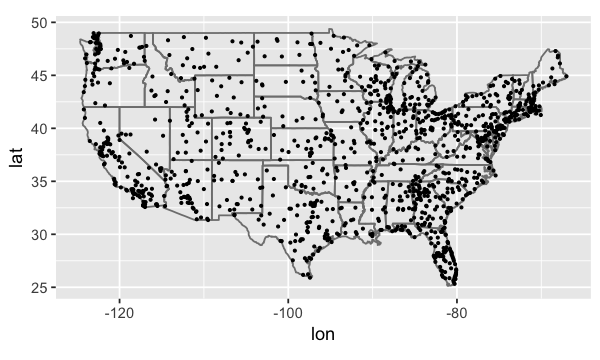

In [50]:
airports %>%
  filter(lon < 0 & between(lat, 25, 50)) %>%  # limiting the map to US mainland boarders for clarity
  ggplot(aes(lon, lat)) +
    borders("state") +
    geom_point(size = 0.5) +
    coord_quickmap()

In [51]:
# Your answer goes here.

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="filterjoin"></a>
### Filtering Joins 
Filtering joins match observations in the same way as mutating joins, but affect the observations, not the variables. There are two types:

* `semi_join(x, y)` **keeps** all observations in `x` that have a match in `y`.
* `anti_join(x, y)` **drops** all observations in `x` that have a match in `y`.

Semi-joins are useful for matching filtered summary tables back to the original rows. For example:

In [52]:
# Top 10 most favorite destinations
top_dest <- flights %>%
  count(dest, sort = TRUE) %>%
  head(10)

The following gives all the flight records to the top 10 destinations:

In [53]:
flights %>% 
  semi_join(top_dest) %>%
  print

Joining, by = "dest"


# A tibble: 141,145 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      542            540         2      923            850
 2  2013     1     1      554            600        -6      812            837
 3  2013     1     1      554            558        -4      740            728
 4  2013     1     1      555            600        -5      913            854
 5  2013     1     1      557            600        -3      838            846
 6  2013     1     1      558            600        -2      753            745
 7  2013     1     1      558            600        -2      924            917
 8  2013     1     1      558            600        -2      923            937
 9  2013     1     1      559            559         0      702            706
10  2013     1     1      600            600         0      851            858
# ... with 141,135 more row

Graphically, a semi-join looks like this:

<img src="../png/semi-join.png" align="center" width="450px">

Only the existence of a match is important; it doesn't matter which observation is matched. This means that filtering joins never duplicate rows like mutating joins do.

The inverse of a semi-join is an anti-join. An anti-join keeps the rows that don't have a match:

<img src="../png/anti-join.png" align="center" width="450px">

Anti-joins are useful for diagnosing join mismatches. For example, when connecting flights and planes, you might be interested to know that there are many flights that don't have a match in `planes`:

In [54]:
flights %>%
  anti_join(planes, by = "tailnum") %>%
  count(tailnum, sort = TRUE) %>%
  print

# A tibble: 722 x 2
   tailnum     n
   <chr>   <int>
 1 <NA>     2512
 2 N725MQ    575
 3 N722MQ    513
 4 N723MQ    507
 5 N713MQ    483
 6 N735MQ    396
 7 N0EGMQ    371
 8 N534MQ    364
 9 N542MQ    363
10 N531MQ    349
# ... with 712 more rows


---
#### Exercise 6
What does it mean for a flight to have a missing `tailnum`? What do the tail numbers that don't have a matching record in planes have in common? (Hint: one variable explains ~90% of the problems.)

In [55]:
# Your answer goes here

---
#### Exercise 7
Filter `flights` to only show flights with planes that have flown at least 100 flights.

In [56]:
# Your answer goes here

---
#### Exercise 8
* What does `anti_join(flights, airports, by = c("dest" = "faa"))` tell you? 
* What does `anti_join(airports, flights, by = c("faa" = "dest"))` tell you?

In [57]:
# Your answer goes here

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="problems"></a>
### Join problems
We have been working with clean data, this is often not the case in real world. Have the following points in mind when joining dataframes to avoid making mistakes:

1. Start by identifying the variables that form the primary key in each table. You should usually do this based on your understanding of the data, not empirically by looking for a combination of variables that give a unique identifier. If you just look for variables without thinking about what they mean, you might get (un)lucky and find a combination that's unique in your current data but the relationship might not be true in general.
    * For example, the altitude and longitude uniquely identify each airport, but they are not good identifiers!


2. Check that none of the variables in the primary key are missing. If a value is missing then it can't identify an observation!


3. Check that your foreign keys match primary keys in another table. The best way to do this is with an `anti_join()`. It's common for keys not to match because of data entry errors. Fixing these is often a lot of work.


4. Be aware that simply checking the number of rows before and after the join is not sufficient to ensure that your join has gone smoothly. If you have an inner join with duplicate keys in both tables, you might get unlucky as the number of dropped rows might exactly equal the number of duplicated rows!

<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>

---
<a class="anchor" id="set"></a>
### Set operations
All these operations work with a complete row, comparing the values of every variable. These expect the `x` and `y` inputs to have the same variables, and treat the observations like sets:

* `intersect(x, y)`: return only observations in both `x` and `y`.
* `union(x, y)`: return unique observations in `x` and `y`.
* `setdiff(x, y)`: return observations in `x`, but not in `y`.

Given this simple data:

In [58]:
df1 <- tribble(
  ~x, ~y,
   1,  1,
   2,  1
)
df2 <- tribble(
  ~x, ~y,
   1,  1,
   1,  2
)

The four possibilities are:

In [59]:
intersect(df1, df2)

x,y
1,1


note that union automatically filters the overlapping records, hence 3 rows!

In [60]:
union(df1, df2)

x,y
1,2
2,1
1,1


In [61]:
setdiff(df1, df2)

x,y
2,1


In [62]:
setdiff(df2, df1)

x,y
1,2


<div style="text-align: right"> [[Jump to top]](#jump_to_top) </div>